In [22]:
import os
#Needed for deterministic behavior
#os.environ["CUBLAS_WORKSPACE_CONFIG"]= ":16:8"
#os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

!pip install -q -r requirements.txt


[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: C:\Users\larin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
%matplotlib inline

#import pytorch-fid
import time
import datetime
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from matplotlib.animation import FuncAnimation
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm
from torchvision import datasets, transforms
import torchvision.transforms as T
from torch.autograd import Variable
import os 
import sys
from PIL import Image

In [4]:
class MLPGenerator(torch.nn.Module):
    
    def __init__(self, 
                 number_of_hidden_layers: int, 
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP generator"""
        
        super().__init__()
        self.label_emb = torch.nn.Embedding(2,2)
        assert number_of_hidden_layers >= 0, "Generator number_of_hidden_layers must be at least 0"
        
        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        # final output should be the size of a true example
        dims_out = [hidden_size] * number_of_hidden_layers + [output_size] 
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))
            
            if i < number_of_hidden_layers:
                layers.append(activation)
        
        # apply Sigmoid after final layer to constrain generated images to [0, 1]
        layers.append(torch.nn.Sigmoid())
        
        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor, labels):
        c = self.label_emb(labels)
        xx = torch.cat([z,c],1)
        return self.net(xx)

class MLPDiscriminator(torch.nn.Module):
    
    def __init__(self, 
                 number_of_hidden_layers: int, 
                 input_size: int, 
                 hidden_size: int, 
                 activation: torch.nn.Module):
        """Construct a simple MLP discriminator"""
        
        super().__init__()
        self.label_emb = torch.nn.Embedding(2,2)
        msg = "Discriminator number_of_hidden_layers must be at least 0"
        assert number_of_hidden_layers >= 0, msg
        
        # final output dimension is scalar (probability image is real)
        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [1]
        
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))
            
            if i < number_of_hidden_layers:
                layers.append(activation)
        
        # apply sigmoid after final layer to represent probability
        layers.append(torch.nn.Sigmoid())
        
        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor, labels):
        c = self.label_emb(labels)
        xx = torch.cat([x,c],1)
        return self.net(xx)

class Model(torch.nn.Module):
    def __init__(self,
                 number_of_hidden_layers: int, 
                 latent_size: int, 
                 hidden_size: int, 
                 output_size: int,
                 activation_generator: torch.nn.Module = torch.nn.ReLU(),
                 activation_discriminator: torch.nn.Module = torch.nn.LeakyReLU(0.2)
                ):
        
        super().__init__()
                          
        self.generator = MLPGenerator(
            number_of_hidden_layers=number_of_hidden_layers, 
            input_size=latent_size+2, 
            hidden_size=hidden_size, 
            output_size=output_size,
            activation=activation_generator
        )
        
        self.discriminator = MLPDiscriminator(
            number_of_hidden_layers=number_of_hidden_layers, 
            input_size=output_size+2, 
            hidden_size=hidden_size,
            activation=activation_discriminator
        )

In [5]:
def load_data(batch_size: int = 128):
    """
    Load dataset.
    :return: DataLoader object
    """

    cuda_kwargs = {
        'num_workers': 1,
        'pin_memory': True,
        'shuffle': True
    } if torch.cuda.is_available() else {}

    # format image data, but do not normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    transform = transforms.Compose(
        [transforms.Grayscale(num_output_channels=1),
         transforms.ToTensor()])
    path = "image_data/cleaned_train"
    dataset = datasets.ImageFolder(path,transform)
    # load data
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        **cuda_kwargs
    )
    return loader

In [6]:
# Training hyperparameters that you shouldn't need to change.
# Consider changing batch size only if you are trying to speed up your training.
image_size = 128 #28
batch_size = 64

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is",device)

# load MNIST dataset
mnist = load_data(batch_size=batch_size)

# discriminator loss function: binary cross-entropy loss
discrim_loss_func = torch.nn.BCELoss()

# determine which labels will correspond to "real" and "fake" predictions from the discriminator
label_real = 1.0
label_fake = 0.0

Device is cpu


In [41]:
    # Training hyperparameters
    hidden_size = 1024
    number_of_hidden_layers = 2
    learning_rate = 0.0008
    epochs = 120
    latent_size = 100

In [42]:
# fix random seed
np.random.seed(1)
torch.manual_seed(1)
#torch.use_deterministic_algorithms(True)

# initialize the model
model = Model(
    number_of_hidden_layers=number_of_hidden_layers, 
    latent_size=latent_size, 
    hidden_size=hidden_size, 
    output_size=image_size*image_size, 
).to(device)

# log metrics
loss_d = np.zeros(epochs)
loss_g = np.zeros(epochs)

optimizer_discriminator = torch.optim.Adam(model.discriminator.parameters(), lr=learning_rate)
optimizer_generator = torch.optim.Adam(model.generator.parameters(), lr=learning_rate)

print("Starting Training!")
startTime = time.time()
for epoch in range(epochs):
    total_epoch_size = 0

    for batch_idx, batch_data in enumerate(mnist):

        x_real, y_real = batch_data
        
        # flatten input images and move to device
        x_real = x_real.to(device)
        y_real = y_real.to(device)
        n_batch = x_real.shape[0]
        x_real = x_real.reshape(n_batch, -1)

        # TODO: write your training code here to compute loss functions
        #   and use optimizer(s) to update your parameters
        loss_discriminator = torch.tensor(0)
        loss_generator = torch.tensor(0)

         # Train discriminator
        optimizer_discriminator.zero_grad()

        # Generate fake images
        z = torch.randn(n_batch, latent_size).to(device)
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 2, n_batch))).to(device)
        x_fake = model.generator(z, fake_labels).to(device)

        # Compute discriminator loss for real and fake images
        y_real_pred = model.discriminator(x_real, y_real)
        y_fake_pred = model.discriminator(x_fake.detach(),fake_labels)

        loss_real = discrim_loss_func(y_real_pred, torch.full((n_batch, 1), label_real).to(device))
        loss_fake = discrim_loss_func(y_fake_pred, torch.full((n_batch, 1), label_fake).to(device))
        loss_discriminator = (loss_real + loss_fake)
        
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Train generator
        optimizer_generator.zero_grad()

        # Generate fake images again and compute generator loss
        y_fake_pred = model.discriminator(x_fake.detach(), fake_labels)
        loss_generator = discrim_loss_func(y_fake_pred, torch.full((n_batch, 1), label_real).to(device))

        loss_generator.backward()
        optimizer_generator.step()

        # Train generator again for n times
        num_repeat = 1
        for i in range(num_repeat):
            optimizer_generator.zero_grad()

            # Generate fake images again and compute generator loss
            y_fake_pred = model.discriminator(x_fake, fake_labels)
            loss_generator = discrim_loss_func(y_fake_pred, torch.full((n_batch, 1), label_real).to(device))

            loss_generator.backward()
            optimizer_generator.step()

        # Encode and decode real images
        #z_encoded = model.encoder(x_real)
        #x_decoded = model.generator(z_encoded)
        
        # log losses and scores
        loss_d[epoch] += loss_discriminator.detach().item() * n_batch
        loss_g[epoch] += loss_generator.detach().item() * n_batch
        total_epoch_size += n_batch

    loss_d[epoch] /= total_epoch_size
    loss_g[epoch] /= total_epoch_size

    #if epoch == 0 or (epoch + 1) % max(1, epochs // 10) == 0:
    total = loss_g[epoch] + loss_d[epoch]
    duration = round(time.time() - startTime)
    log = "  ".join([
        f"Epoch: {epoch + 1:4d}",
        f"Gen Loss: {loss_g[epoch]:8.1f}",
        f"Dis Loss: {loss_d[epoch]:8.1f}",
        f"Total: {total:8.1f}",
        f"Time: {(duration//3600):02.0f}:{((duration%3600)//60):02.0f}:{(duration%60):02.0f}"
    ])
    print(log)

Starting Training!
Epoch:    1  Gen Loss:     96.5  Dis Loss:     95.8  Total:    192.3  Time: 00:00:50
Epoch:    2  Gen Loss:    100.0  Dis Loss:    100.0  Total:    200.0  Time: 00:01:37
Epoch:    3  Gen Loss:    100.0  Dis Loss:    100.0  Total:    200.0  Time: 00:02:25
Epoch:    4  Gen Loss:    100.0  Dis Loss:    100.0  Total:    200.0  Time: 00:03:12
Epoch:    5  Gen Loss:    100.0  Dis Loss:    100.0  Total:    200.0  Time: 00:03:59
Epoch:    6  Gen Loss:    100.0  Dis Loss:    100.0  Total:    200.0  Time: 00:04:46
Epoch:    7  Gen Loss:    100.0  Dis Loss:    100.0  Total:    200.0  Time: 00:05:34
Epoch:    8  Gen Loss:    100.0  Dis Loss:    100.0  Total:    200.0  Time: 00:06:34
Epoch:    9  Gen Loss:    100.0  Dis Loss:    100.0  Total:    200.0  Time: 00:07:56
Epoch:   10  Gen Loss:    100.0  Dis Loss:    100.0  Total:    200.0  Time: 00:09:22
Epoch:   11  Gen Loss:    100.0  Dis Loss:    100.0  Total:    200.0  Time: 00:10:46
Epoch:   12  Gen Loss:    100.0  Dis Loss:    

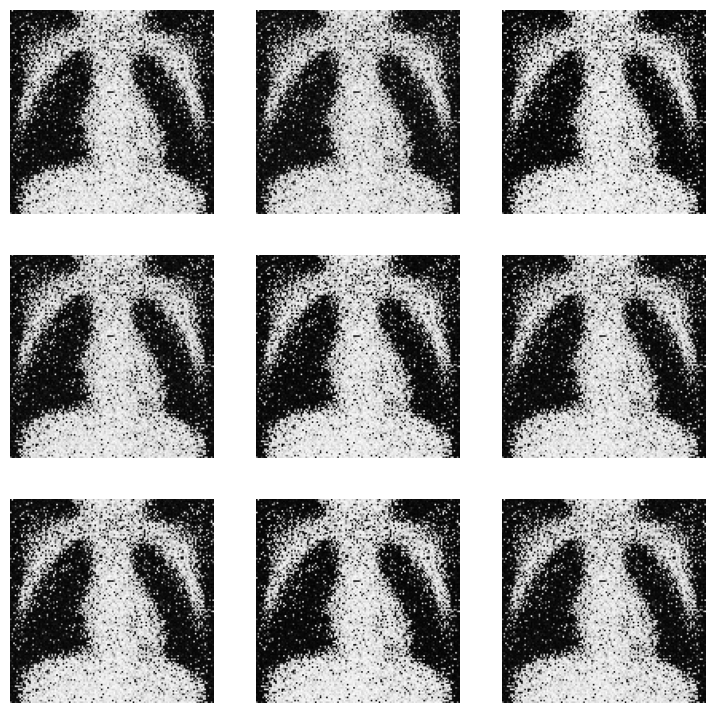

In [43]:
nrows, ncols = (3, 3)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * nrows, 3 * ncols))

for row in range(nrows):
    for col in range(ncols):
        z = torch.randn(1, latent_size).to(device)
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 2, 1))).to(device)
        output = model.generator(z,fake_labels).reshape(image_size, image_size).detach().cpu()
        axes[row, col].imshow(output.squeeze(), cmap='gray')
        axes[row, col].axis('off')

plt.show()
transform = T.ToPILImage()

for i in range(10):
    z = torch.randn(1, latent_size).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 1, 1))).to(device)
    output = model.generator(z,fake_labels).reshape(image_size, image_size).detach().cpu()
    output = transform(output.squeeze())
    output.save(os.path.join(sys.path[0], f"output_data/NORMAL/img{i}.jpeg"))
    

for i in range(10):
    z = torch.randn(1, latent_size).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(1, 2, 1))).to(device)
    output = model.generator(z,fake_labels).reshape(image_size, image_size).detach().cpu()
    output = transform(output.squeeze())
    output.save(os.path.join(sys.path[0], f"output_data/PNEUMONIA/img{i}.jpeg"))

In [44]:
!python3 -m pytorch_fid output_data/NORMAL image_data/cleaned_test/NORMAL

FID:  485.93007972098



100%|██████████| 1/1 [00:06<00:00,  6.50s/it]

100%|██████████| 5/5 [00:34<00:00,  6.96s/it]


In [45]:
!python -m pytorch_fid output_data/PNEUMONIA image_data/cleaned_test/PNEUMONIA

FID:  508.7728921419288



100%|██████████| 1/1 [00:06<00:00,  6.25s/it]

100%|██████████| 8/8 [00:56<00:00,  7.08s/it]
